In [3]:
using JLD
using PyPlot
using Statistics, StatsBase #mean and std

In [33]:
nombrecm="../JLDFiles/Evocada/CSDEvocada_3R7-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];

In [5]:
function leeunmegaarrayarchivos(NomineGeneralis::AbstractString, desde=35, hasta=501)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
            readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
    end


function leunjlddeCM(datos, desde=1, hasta=300)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
        readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end



leunjlddeCM (generic function with 3 methods)

Para Evocados, hay un par de variables temporales para considerar:
- retrazo: el tiempo en cuadros que hubo desde el comienzo del registro hasta el estimulo
- latencia: el tiempo en cuadros que hubo desde el estimulo hasta que paso algo interesante


In [16]:
freq=7.022 # la frecuencia de muestreo en kHz de los experimentos viejos
retms=5.0 #retrazo en milisec
latms=4.0 #latencia en milisec
retrazo=round(Int, retms * freq)
lat=round(Int, latms * freq)
desde=retrazo+lat
hasta=300

300

In [17]:
function dist2D(x,y)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

function difgordis(x,y)
    result=abs(x-y)/max(abs(x),abs(y))
    return result
end

difgordis (generic function with 1 method)

In [18]:
difgordis(0.21,0.29)

0.27586206896551724

In [19]:
function encuentraTrayectorias(Datos, mincadena=20, mingordo=2.0, desde=1,hasta=20)

toleradist=16.0*sqrt(2)
#toldifgordis=0.33
tau=1
t=1
j=1
Catenario=Dict{Integer, Array{Any}}()
Cadena=[0 0 0 0]
tnum=1
CopiaMegaArray=deepcopy(Datos);
NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
 
        if(CopiaMegaArray[tau]==[])
            
            jmax,nada=0,0
        else
          
     jmax,nada= size(CopiaMegaArray[tau])
        end
    
        
    while j <=jmax && tau<FakeNumFrames
            
            if abs(CopiaMegaArray[tau][j,3]) > mingordo
                
            Eslabon=[transpose(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
                
                if CopiaMegaArray[tau+1]==[]
                    kmax,nada=0,0
                else
                kmax, nada= size(CopiaMegaArray[tau+1])
                end
                huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>mingordo
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[transpose(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    # veamos si funciona  mejor como dict 
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
        end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 5 methods)

In [34]:
#Recuerda el segundo argumento es la longitud mínima de la cadena
@time CatenarioPositivo=encuentraTrayectorias(DatosCMP,3,5,desde,hasta);


  0.063519 seconds (244.25 k allocations: 13.343 MiB, 25.69% gc time)


In [35]:
CatenarioNegativo=encuentraTrayectorias(DatosCMN,3,5,desde,hasta);

In [39]:
nombreout=nombrecm[1:end-6]*"Tray-todas.jld"
save(nombreout, "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo)

In [40]:
length(CatenarioPositivo), length(CatenarioNegativo)

(96, 83)

In [41]:
nombreout

"../JLDFiles/Evocada/CSDEvocada_3R7-Tray-todas.jld"

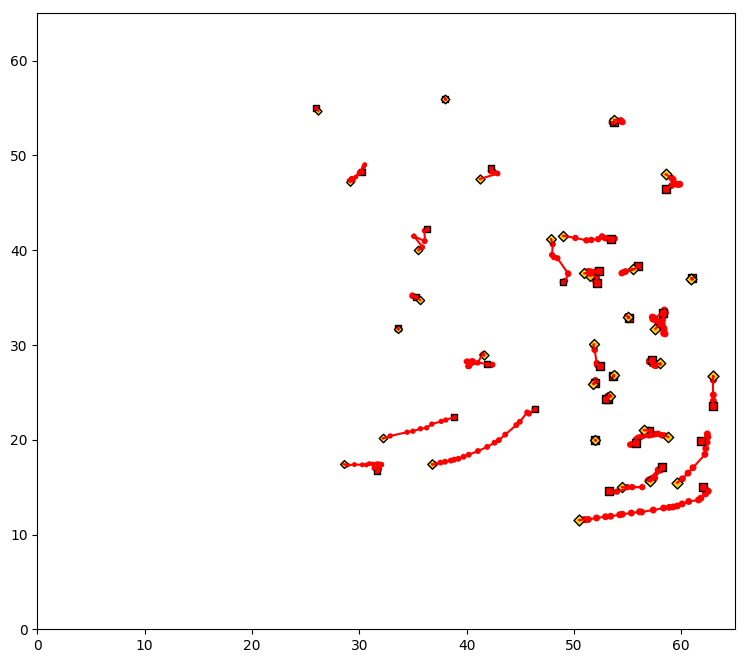

In [42]:
PyPlot.ion()
figure(figsize=(9,8))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tolerancia=25
minlong=7
maxlong=100
#colores=Union{}

for p in values(CatenarioPositivo)
    gordura=abs(p[:3])
    longus,gordus=size(p)
    if (mean(gordura)>tolerancia) && (longus>minlong) && longus < maxlong
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=0.25, color="r")
        colores=scatter(xxpos,yypos, s=gordura*0.4, edgecolors="none", 
        c=tiempos, cmap="autumn", vmin=0.0, vmax=0.72 )
        principios=scatter(xxpos[1],yypos[1], s=gordura*0.5,
        edgecolors="black", 
        color="r", marker="s", label="Inicio" )
        finales=scatter(xxpos[end],yypos[end], s=gordura*0.5, edgecolors="black", 
        color="gold", marker="D", label="Final" )
        # annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
        # annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

#savefig("ejemploaltaspositivas-01.svg",dpi=92)

In [26]:
values(CatenarioNegativo)

Base.ValueIterator for a Dict{Integer,Array{Any,N} where N} with 49 entries. Values:
  Any[26.0013 55.088 -2483.63 1.0; 25.9281 55.1359 -2536.19 2.0; … ; 26.252 55.…
  Any[60.0665 48.1529 -11285.5 37.0; 58.5928 48.816 -14123.2 38.0; … ; 60.7554 …
  Any[57.0717 20.8273 -893.858 266.0; 57.0121 20.9801 -1487.13 267.0; … ; 54.74…
  Any[59.8827 36.2366 -662.705 340.0; 60.1055 35.2429 -1671.05 341.0; … ; 59.92…
  Any[46.0328 23.5231 -482.692 55.0; 46.0322 23.4967 -561.517 56.0; … ; 41.3692…
  Any[54.7044 22.2003 -10563.8 298.0; 54.7015 22.2252 -10625.3 299.0; … ; 54.75…
  Any[46.2107 19.1913 -385.022 74.0; 46.5183 19.0278 -498.873 75.0; … ; 46.6269…
  Any[44.4036 46.9165 -2402.79 34.0; 42.9937 46.1832 -7759.53 35.0; … ; 42.3591…
  Any[30.1005 19.2671 -898.828 41.0; 29.9422 19.1648 -740.373 42.0; … ; 29.9397…
  Any[41.1494 30.0006 -1348.46 40.0; 41.1503 30.0294 -942.735 41.0; … ; 41.1256…
  Any[55.9736 15.7986 -10635.2 75.0; 55.6318 15.6515 -9996.41 76.0; … ; 54.1762…
  Any[43.4478 15.4463 -4